In [1]:
from __future__ import print_function
import tensorflow as tf
import keras

from keras.models import Sequential
from keras.layers import LSTM
from keras import initializers
from keras.optimizers import RMSprop
from keras.layers import Dense, Dropout
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf 
from sklearn import metrics
import h5py
import os

import keras
from keras.models import Sequential
from keras.layers import Conv1D, Conv2D, Conv3D, MaxPooling1D,MaxPooling2D, AveragePooling2D, Reshape
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import regularizers
from keras.optimizers import SGD

/Users/luwenfei/Desktop/EE239A/HW1/.env/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# load data
labels = ["left","right","feet","tongue"]

A01T = h5py.File('A01T_slice.mat', 'r')
X = np.copy(A01T['image'])
y = np.copy(A01T['type'])
y = y[0,0:X.shape[0]:1]
# mask = list(range(238,288))
# X_test = X[mask]
# y_test = y[mask]
for i in range(2,10):
    raw_data = h5py.File('A0'+str(i)+'T_slice.mat', 'r')
    xi = np.copy(raw_data['image'])
    yi = np.copy(raw_data['type'])
    yi = yi[0,0:xi.shape[0]:1]
    X = np.concatenate((X, xi))
    y = np.concatenate((y, yi))

y = np.asarray(y, dtype=np.int32)-769
y = y[:,None]
X = X[:,0:22,:]
X = X.transpose(0,2,1)
where_are_NaNs = np.isnan(X)
X[where_are_NaNs] = 0
print(X.shape)
print(y.shape)

(2592, 1000, 22)
(2592, 1)


In [3]:
mask1 = list(range(50))
X_test1 = X[mask1]
y_test1 = y[mask1]
mask2 = list(range(288,288+50))
X_test2 = X[mask2]
y_test2 = y[mask2]
mask3 = list(range(288*2,288*2+50))
X_test3 = X[mask3]
y_test3 = y[mask3]
mask4 = list(range(288*3,288*3+50))
X_test4 = X[mask4]
y_test4 = y[mask4]
mask5 = list(range(288*4,288*4+50))
X_test5 = X[mask5]
y_test5 = y[mask5]
mask6 = list(range(288*5,288*5+50))
X_test6 = X[mask6]
y_test6 = y[mask6]
mask7 = list(range(288*6,288*6+50))
X_test7 = X[mask7]
y_test7 = y[mask7]
mask8 = list(range(288*7,288*7+50))
X_test8 = X[mask8]
y_test8 = y[mask8]
mask9 = list(range(288*8,288*8+50))
X_test9 = X[mask9]
y_test9 = y[mask9]

mask_train1 = list(range(50,288*9))
X_train1 = X[mask_train1]
y_train1 = y[mask_train1]
mask_train2 = list(range(0,288*1))+list(range(288*1+50,288*9))
X_train2 = X[mask_train2]
y_train2 = y[mask_train2]
mask_train3 = list(range(0,288*2))+list(range(288*2+50,288*9))
X_train3 = X[mask_train3]
y_train3 = y[mask_train3]
mask_train4 = list(range(0,288*3))+list(range(288*3+50,288*9))
X_train4 = X[mask_train4]
y_train4 = y[mask_train4]
mask_train5 = list(range(0,288*4))+list(range(288*4+50,288*9))
X_train5 = X[mask_train5]
y_train5 = y[mask_train5]
mask_train6 = list(range(0,288*5))+list(range(288*5+50,288*9))
X_train6 = X[mask_train6]
y_train6 = y[mask_train6]
mask_train7 = list(range(0,288*6))+list(range(288*6+50,288*9))
X_train7 = X[mask_train7]
y_train7 = y[mask_train7]
mask_train8 = list(range(0,288*7))+list(range(288*7+50,288*9))
X_train8 = X[mask_train8]
y_train8 = y[mask_train8]
mask_train9 = list(range(0,288*8))+list(range(288*8+50,288*9))
X_train9 = X[mask_train9]
y_train9 = y[mask_train9]

In [5]:
num_classes = 4
y_train1 = keras.utils.to_categorical(y_train1, num_classes)
y_test1 = keras.utils.to_categorical(y_test1, num_classes)
y_train2 = keras.utils.to_categorical(y_train2, num_classes)
y_test2 = keras.utils.to_categorical(y_test2, num_classes)
y_train3 = keras.utils.to_categorical(y_train3, num_classes)
y_test3 = keras.utils.to_categorical(y_test3, num_classes)
y_train4 = keras.utils.to_categorical(y_train4, num_classes)
y_test4 = keras.utils.to_categorical(y_test4, num_classes)
y_train5 = keras.utils.to_categorical(y_train5, num_classes)
y_test5 = keras.utils.to_categorical(y_test5, num_classes)
y_train6 = keras.utils.to_categorical(y_train6, num_classes)
y_test6 = keras.utils.to_categorical(y_test6, num_classes)
y_train7 = keras.utils.to_categorical(y_train7, num_classes)
y_test7 = keras.utils.to_categorical(y_test7, num_classes)
y_train8 = keras.utils.to_categorical(y_train8, num_classes)
y_test8 = keras.utils.to_categorical(y_test8, num_classes)
y_train9 = keras.utils.to_categorical(y_train9, num_classes)
y_test9 = keras.utils.to_categorical(y_test9, num_classes)

In [6]:
import time
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = [0]

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(self.times[-1]+time.time() - self.epoch_time_start)
        
class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.testaccuracy = []

    def on_epoch_end(self, batch, logs={}):
        self.testaccuracy.append(logs.get('val_acc'))

In [8]:
epochs = 100  
batch_size = 64

model = Sequential()

# 1st cnn layer: 64 filters of size 11*11 with stride 4
#                POOL: 3*3 filters with stride 2
model.add(Conv1D(filters=64, kernel_size=11, strides=4, padding='valid',activation='relu',kernel_initializer='uniform',input_shape=X_train1.shape[1:]))
model.add(MaxPooling1D(pool_size=3,strides=2))

model.add(Conv1D(filters=192, kernel_size=5, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))
model.add(MaxPooling1D(pool_size=3,strides=2))

model.add(Conv1D(filters=384, kernel_size=3, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))

model.add(Conv1D(filters=256, kernel_size=3, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))

model.add(Conv1D(filters=256, kernel_size=3, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))

model.add(Conv1D(filters=256, kernel_size=3, strides=1, padding='same',activation='relu',kernel_initializer='uniform'))
model.add(MaxPooling1D(pool_size=3,strides=2))

model.add(Flatten())  
model.add(Dense(4096,activation='relu'))  
model.add(Dropout(0.5))  
model.add(Dense(4096,activation='relu'))  
model.add(Dropout(0.5))  
model.add(Dense(4096,activation='relu'))  
model.add(Dropout(0.5))  
model.add(Dense(num_classes,activation='softmax'))  


opt = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.0005, nesterov=False)
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])  
model.summary()  

time_callback = TimeHistory()
acc_callback = AccuracyHistory()
model.fit(X_train1, y_train1, batch_size=batch_size, validation_data=(X_test1,y_test1),callbacks=[time_callback,acc_callback],epochs=epochs)
times = time_callback.times

scores = model.evaluate(X_test1, y_test1, verbose=1)

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 248, 64)           15552     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 123, 64)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 123, 192)          61632     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 61, 192)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 61, 384)           221568    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 61, 256)           295168    
___________________________________________________________

2542/2542 [==============================] - 47s 19ms/step - loss: 0.2580 - acc: 0.9079 - val_loss: 2.2906 - val_acc: 0.4400
Epoch 38/100
2542/2542 [==============================] - 47s 19ms/step - loss: 0.3303 - acc: 0.8773 - val_loss: 2.8398 - val_acc: 0.3800
Epoch 39/100
2542/2542 [==============================] - 48s 19ms/step - loss: 0.1806 - acc: 0.9351 - val_loss: 2.9238 - val_acc: 0.4200
Epoch 40/100
2542/2542 [==============================] - 48s 19ms/step - loss: 0.1857 - acc: 0.9319 - val_loss: 2.8022 - val_acc: 0.3600
Epoch 41/100
2542/2542 [==============================] - 49s 19ms/step - loss: 0.1491 - acc: 0.9485 - val_loss: 2.8975 - val_acc: 0.4000
Epoch 42/100
2542/2542 [==============================] - 49s 19ms/step - loss: 0.1895 - acc: 0.9327 - val_loss: 2.3857 - val_acc: 0.4200
Epoch 43/100
2542/2542 [==============================] - 49s 19ms/step - loss: 0.1603 - acc: 0.9386 - val_loss: 2.9829 - val_acc: 0.4000
Epoch 44/100
2542/2542 [=======================

2542/2542 [==============================] - 48s 19ms/step - loss: 1.7512e-04 - acc: 1.0000 - val_loss: 4.1351 - val_acc: 0.4600
Epoch 97/100
2542/2542 [==============================] - 48s 19ms/step - loss: 1.6419e-04 - acc: 1.0000 - val_loss: 4.1474 - val_acc: 0.4600
Epoch 98/100
2542/2542 [==============================] - 48s 19ms/step - loss: 1.4521e-04 - acc: 1.0000 - val_loss: 4.1421 - val_acc: 0.4600
Epoch 99/100
2542/2542 [==============================] - 48s 19ms/step - loss: 1.1376e-04 - acc: 1.0000 - val_loss: 4.1524 - val_acc: 0.4600
Epoch 100/100
50/50 [==============================] - 0s 7ms/step


0.5


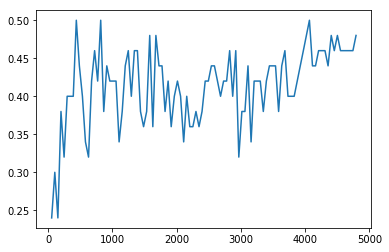

In [9]:
plt.plot(times[1:],acc_callback.testaccuracy)
print(max(acc_callback.testaccuracy))